In [ ]:
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 81kB 2.3MB/s 


In [ ]:
import numpy as np
from sklearn.datasets import load_svmlight_file
import time
from scipy.sparse import csr_matrix
import random

from xgboost import XGBRegressor

# Ignore warnings
import warnings
import copy
warnings.filterwarnings('ignore')

from pyunpack import Archive
import lightgbm as lgbm

In [ ]:
Archive('forColab.rar').extractall('')

In [ ]:
dict_train = dict()
with open("Data/train.marks.tsv", 'r') as f:
  for line in f.readlines():
    tmp = line.strip().split("\t");
    dict_train[tmp[1]] = 1

X_dict = dict()
with open("new_feat/ir_2_result_u/part-r-00000", 'r') as f:
  for line in f.readlines():
    tmp = line.strip().split("\t")
    X_dict[tmp[0]] = [np.float64(i) for i in tmp[1:]]

In [ ]:
y_train = []
query_train = []
X_train_split = []

with open("Data/train.marks.tsv", 'r') as f:
  for line in f.readlines():
    tmp = line.strip().split("\t");
    y_train.append(np.int(tmp[2]))
    query_train.append(np.int(tmp[0]))
    X_train_split.append(tmp[1])

X_train = []
for d in X_train_split:
  if d in X_dict:
    X_train.append(X_dict[d])
  else:
    X_train.append(list(np.zeros(39)))


query_train = np.array(query_train)
y_train = np.array(y_train)
X_train = np.array(X_train)

In [ ]:
query_test = []
y_test = []
X_test_split = []
with open("Data/sample.csv", 'r') as f:
  f.readline()
  for line in f.readlines():
    tmp = line.strip().split(",")
    query_test.append(int(tmp[0]))
    y_test.append(1)
    X_test_split.append(tmp[1])

X_test = []
for d in X_test_split:
  if d in X_dict:
    X_test.append(X_dict[d])
  else:
    X_test.append(list(np.zeros(39)))

query_test = np.array(query_test)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [ ]:
host_dict = dict()
url2host_dict = dict()
id_ = 0
with open('Data/url.data', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        tmp = line.strip().split('\t') 
        tmp_ = tmp[1].split('/')[0]
        if tmp_[:4] =='www.':
            tmp_=tmp_[4:]
        if tmp_ in host_dict:
            url2host_dict[tmp[0]] = host_dict[tmp_]
            continue
        host_dict[tmp_] = str(id_)
        url2host_dict[tmp[0]] = host_dict[tmp_]
        id_ += 1

In [ ]:
dict_url_qu = dict()
for i in range(10):
  with open('new_feat/ir_2_result_uq/part-r-0000'+str(i), 'r') as f:
      for line in f.readlines():
        tmp = line.strip().split("\t")
        if (tmp[0]+"\t"+tmp[1]) in dict_url_qu:
          print('kek')
        dict_url_qu[tmp[0]+"\t"+tmp[1]] = [np.float64(el) for el in tmp[2:]]
with open('new_feat/ir_2_result_uq/part-r-00010', 'r') as f:
  for line in f.readlines():
    tmp = line.strip().split("\t")
    if (tmp[0]+"\t"+tmp[1]) in dict_url_qu:
      print('kek')
    dict_url_qu[tmp[0]+"\t"+tmp[1]] = [np.float64(el) for el in tmp[2:]]

a_url_qu = np.zeros((len(X_train_split), 39))
check = []
tt = 0
for i in range(len(X_train_split)):
  if (str(query_train[i]) + '\t' + X_train_split[i]) in dict_url_qu:
    a_url_qu[i] = dict_url_qu[str(query_train[i]) + '\t' + X_train_split[i]]
    check.append(str(query_train[i]) + '\t' + X_train_split[i])
    tt += 1

b_url_qu = np.zeros((len(X_test_split), 39))
check = []
tt = 0
for i in range(len(X_test_split)):
  if (str(query_test[i]) + '\t' + X_test_split[i]) in dict_url_qu:
    b_url_qu[i] = dict_url_qu[str(query_test[i]) + '\t' + X_test_split[i]]
    check.append(str(query_test[i]) + '\t' + X_test_split[i])
    tt += 1

In [ ]:
dict_host_qu = dict()
for i in range(10):
  with open('new_feat/ir_2_result_hq/part-r-0000'+str(i), 'r') as f:
      for line in f.readlines():
        tmp = line.strip().split("\t")
        if (tmp[0]+"\t"+tmp[1]) in dict_host_qu:
          print('kek')
        dict_host_qu[tmp[0]+"\t"+tmp[1]] = [np.float64(el) for el in tmp[2:]]
with open('new_feat/ir_2_result_hq/part-r-00010', 'r') as f:
  for line in f.readlines():
    tmp = line.strip().split("\t")
    if (tmp[0]+"\t"+tmp[1]) in dict_host_qu:
      print('kek')
    dict_host_qu[tmp[0]+"\t"+tmp[1]] = [np.float64(el) for el in tmp[2:]]

a_host_qu = np.zeros((len(X_train_split), 39))
check = []
tt = 0
for i in range(len(X_train_split)):
  if (str(query_train[i]) + '\t' + url2host_dict[X_train_split[i]]) in dict_host_qu:
    a_host_qu[i] = dict_host_qu[str(query_train[i]) + '\t' + url2host_dict[X_train_split[i]]]
    check.append(str(query_train[i]) + '\t' + X_train_split[i])
    tt += 1

b_host_qu = np.zeros((len(X_test_split), 39))
check = []
tt = 0
for i in range(len(X_test_split)):
  if (str(query_test[i]) + '\t' + url2host_dict[X_test_split[i]]) in dict_host_qu:
    b_host_qu[i] = dict_host_qu[str(query_test[i]) + '\t' + url2host_dict[X_test_split[i]]]
    check.append(str(query_test[i]) + '\t' + X_test_split[i])
    tt += 1

In [ ]:
dict_host = dict()
with open('new_feat/ir_2_result_h/part-r-00000', 'r') as f:
  for line in f.readlines():
    tmp = line.strip().split("\t")
    if (tmp[0]) in dict_host:
      print('kek')
    dict_host[tmp[0]] = [np.float64(el) for el in tmp[1:]]

a_host = np.zeros((len(X_train_split), 39))
check = []
tt = 0
for i in range(len(X_train_split)):
  if url2host_dict[X_train_split[i]] in dict_host:
    a_host[i] = dict_host[url2host_dict[X_train_split[i]]]
    check.append(X_train_split[i])
    tt += 1

b_host = np.zeros((len(X_test_split), 39))
check = []
tt = 0
for i in range(len(X_test_split)):
  if url2host_dict[X_test_split[i]] in dict_host:
    b_host[i] = dict_host[url2host_dict[X_test_split[i]]]
    check.append(X_test_split[i])
    tt += 1

In [ ]:
dict_qu = dict()
with open('new_feat/ir_2_result_q/part-r-00000', 'r') as f:
  for line in f.readlines():
    tmp = line.strip().split("\t")
    if (tmp[0]) in dict_qu:
      print('kek')
    dict_qu[tmp[0]] = [np.float64(el) for el in tmp[1:]]

a_qu = np.zeros((len(X_train_split), 8))
tt = 0
for i in range(len(X_train_split)):
  if str(query_train[i]) in dict_qu:
    a_qu[i] = dict_qu[str(query_train[i])]
    tt += 1

b_qu = np.zeros((len(X_test_split), 8))
tt = 0
for i in range(len(X_test_split)):
  if str(query_test[i]) in dict_qu:
    b_qu[i] = dict_qu[str(query_test[i])]
    tt += 1


In [ ]:
arr_query_unic = []
with open('Data/sample.csv','r', encoding='utf-8') as f:
  f.readline()
  for line in f.readlines():
    tmp = line.strip().split(',')
    arr_query_unic.append(tmp[0])
with open('Data/train.marks.tsv','r', encoding='utf-8') as f:
  for line in f.readlines():
    tmp = line.strip().split('\t')
    arr_query_unic.append(tmp[0])
arr_query_unic = np.unique(arr_query_unic)

In [ ]:
tf = dict()
for q in arr_query_unic:
  with open('tf_idf_body/'+q+'.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
      tmp = line.strip().split('\t')
      tf[tmp[0]+'\t'+tmp[1]] = tmp[2]

a_tf = np.zeros((len(X_train_split), 1))
tt = 0
for i in range(len(X_train_split)):
  if (str(query_train[i]) + '\t' + X_train_split[i]) in tf:
    a_tf[i] = tf[str(query_train[i]) + '\t' + X_train_split[i]]
    tt += 1

b_tf = np.zeros((len(X_test_split), 1))
#check = []
tt = 0
for i in range(len(X_test_split)):
  if (str(query_test[i]) + '\t' + X_test_split[i]) in tf:
    b_tf[i] = tf[str(query_test[i]) + '\t' + X_test_split[i]]
    tt += 1

In [ ]:
tf_title_2_3 = dict()
with open('feat_title/сosine_tfidf_char2_3.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
      tmp = line.strip().split('\t')
      tf_title_2_3[tmp[0]+'\t'+tmp[1]] = tmp[2]

a_tf_title_2_3 = np.zeros((len(X_train_split), 1))
tt = 0
for i in range(len(X_train_split)):
  if (str(query_train[i]) + '\t' + X_train_split[i]) in tf_title_2_3:
    a_tf_title_2_3[i] = tf_title_2_3[str(query_train[i]) + '\t' + X_train_split[i]]
    tt += 1

b_tf_title_2_3 = np.zeros((len(X_test_split), 1))
#check = []
tt = 0
for i in range(len(X_test_split)):
  if (str(query_test[i]) + '\t' + X_test_split[i]) in tf_title_2_3:
    b_tf_title_2_3[i] = tf_title_2_3[str(query_test[i]) + '\t' + X_test_split[i]]
    tt += 1

In [ ]:
tf_title_3_13 = dict()
with open('feat_title/сosine_tfidf_char3_13.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
      tmp = line.strip().split('\t')
      tf_title_3_13[tmp[0]+'\t'+tmp[1]] = tmp[2]

a_tf_title_3_13 = np.zeros((len(X_train_split), 1))
tt = 0
for i in range(len(X_train_split)):
  if (str(query_train[i]) + '\t' + X_train_split[i]) in tf_title_3_13:
    a_tf_title_3_13[i] = tf_title_3_13[str(query_train[i]) + '\t' + X_train_split[i]]
    tt += 1

b_tf_title_3_13 = np.zeros((len(X_test_split), 1))
check = []
tt = 0
for i in range(len(X_test_split)):
  if (str(query_test[i]) + '\t' + X_test_split[i]) in tf_title_3_13:
    b_tf_title_3_13[i] = tf_title_3_13[str(query_test[i]) + '\t' + X_test_split[i]]
    tt += 1

In [ ]:
dict_sDBN_qu = dict()
with open('new_feat/ir_2_result_sDBN/QURLS/part-r-00000', 'r') as f:
  for line in f.readlines():
    tmp = line.strip().split("\t")
    if (tmp[0]+"\t"+tmp[1]) in dict_sDBN_qu:
      print('kek')
    dict_sDBN_qu[tmp[0]+"\t"+tmp[1]] = [np.float64(el) for el in tmp[2:]]

a_sDBN_qu = np.zeros((len(X_train_split), 3))
tt = 0
for i in range(len(X_train_split)):
  if (str(query_train[i]) + '\t' + X_train_split[i]) in dict_sDBN_qu:
    a_sDBN_qu[i] = dict_sDBN_qu[str(query_train[i]) + '\t' + X_train_split[i]]
    tt += 1

b_sDBN_qu = np.zeros((len(X_test_split), 3))
tt = 0
for i in range(len(X_test_split)):
  if (str(query_test[i]) + '\t' + X_test_split[i]) in dict_sDBN_qu:
    b_sDBN_qu[i] = dict_sDBN_qu[str(query_test[i]) + '\t' + X_test_split[i]]
    tt += 1

In [ ]:
dict_sDBN_qh = dict()
with open('new_feat/ir_2_result_sDBN/QHOST/part-r-00000', 'r') as f:
  for line in f.readlines():
    tmp = line.strip().split("\t")
    if (tmp[0]+"\t"+tmp[1]) in dict_sDBN_qh:
      print('kek')
    dict_sDBN_qh[tmp[0]+"\t"+tmp[1]] = [np.float64(el) for el in tmp[2:]]

a_sDBN_qh = np.zeros((len(X_train_split), 3))
tt = 0
for i in range(len(X_train_split)):
  if (str(query_train[i]) + '\t' + url2host_dict[X_train_split[i]]) in dict_sDBN_qh:
    a_sDBN_qh[i] = dict_sDBN_qh[str(query_train[i]) + '\t' + url2host_dict[X_train_split[i]]]
    tt += 1

b_sDBN_qh = np.zeros((len(X_test_split), 3))
tt = 0
for i in range(len(X_test_split)):
  if (str(query_test[i]) + '\t' + url2host_dict[X_test_split[i]]) in dict_sDBN_qh:
    b_sDBN_qh[i] = dict_sDBN_qh[str(query_test[i]) + '\t' + url2host_dict[X_test_split[i]]]
    tt += 1

In [ ]:
dict_sDBN_h = dict()
with open('new_feat/ir_2_result_sDBN/HOST/part-r-00000', 'r') as f:
  for line in f.readlines():
    tmp = line.strip().split("\t")
    if (tmp[0]) in dict_sDBN_h:
      print('kek')
    dict_sDBN_h[tmp[0]] = [np.float64(el) for el in tmp[1:]]

a_sDBN_h = np.zeros((len(X_train_split), 3))
tt = 0
for i in range(len(X_train_split)):
  if url2host_dict[X_train_split[i]] in dict_sDBN_h:
    a_sDBN_h[i] = dict_sDBN_h[url2host_dict[X_train_split[i]]]
    tt += 1

b_sDBN_h = np.zeros((len(X_test_split), 3))
tt = 0
for i in range(len(X_test_split)):
  if url2host_dict[X_test_split[i]] in dict_sDBN_h:
    b_sDBN_h[i] = dict_sDBN_h[url2host_dict[X_test_split[i]]]
    tt += 1

In [ ]:
dict_sDBN_u = dict()
with open('new_feat/ir_2_result_sDBN/URLS/part-r-00000', 'r') as f:
  for line in f.readlines():
    tmp = line.strip().split("\t")
    if (tmp[0]) in dict_sDBN_u:
      print('kek')
    dict_sDBN_u[tmp[0]] = [np.float64(el) for el in tmp[1:]]

a_sDBN_u = np.zeros((len(X_train_split), 3))
tt = 0
for i in range(len(X_train_split)):
  if X_train_split[i] in dict_sDBN_u:
    a_sDBN_u[i] = dict_sDBN_u[X_train_split[i]]
    tt += 1

b_sDBN_u = np.zeros((len(X_test_split), 3))
tt = 0
for i in range(len(X_test_split)):
  if X_test_split[i] in dict_sDBN_u:
    b_sDBN_u[i] = dict_sDBN_u[X_test_split[i]]
    tt += 1

In [ ]:
fasttext_dict = dict()
with open('feat_title/fasttextfeat.txt','r',encoding='utf-8') as f:
  for line in f.readlines():
    tmp = line.strip().split('\t')
    fasttext_dict[tmp[0]+'\t'+tmp[1]] = np.float64(tmp[2])

a_fasttext = np.zeros((len(X_train_split), 1))
tt = 0
for i in range(len(X_train_split)):
  if (str(query_train[i]) + '\t' + X_train_split[i]) in fasttext_dict:
    a_fasttext[i] = fasttext_dict[str(query_train[i]) + '\t' + X_train_split[i]]
    tt += 1

b_fasttext = np.zeros((len(X_test_split), 1))
tt = 0
for i in range(len(X_test_split)):
  if (str(query_test[i]) + '\t' + X_test_split[i]) in fasttext_dict:
    b_fasttext[i] = fasttext_dict[str(query_test[i]) + '\t' + X_test_split[i]]
    tt += 1


In [ ]:
bm25_dict = dict()
with open('feat_title/сosine_bm25.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
      tmp = line.strip().split('\t')
      bm25_dict[tmp[0]+'\t'+tmp[1]] = tmp[2]

a_bm25_dict = np.zeros((len(X_train_split), 1))
tt = 0
for i in range(len(X_train_split)):
  if (str(query_train[i]) + '\t' + X_train_split[i]) in bm25_dict:
    a_bm25_dict[i] = bm25_dict[str(query_train[i]) + '\t' + X_train_split[i]]
    tt += 1

b_bm25_dict = np.zeros((len(X_test_split), 1))
check = []
tt = 0
for i in range(len(X_test_split)):
  if (str(query_test[i]) + '\t' + X_test_split[i]) in bm25_dict:
    b_bm25_dict[i] = bm25_dict[str(query_test[i]) + '\t' + X_test_split[i]]
    tt += 1

bm25L_dict = dict()
with open('feat_title/сosine_bm25L.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
      tmp = line.strip().split('\t')
      bm25L_dict[tmp[0]+'\t'+tmp[1]] = tmp[2]

a_bm25L_dict = np.zeros((len(X_train_split), 1))
tt = 0
for i in range(len(X_train_split)):
  if (str(query_train[i]) + '\t' + X_train_split[i]) in bm25L_dict:
    a_bm25L_dict[i] = bm25L_dict[str(query_train[i]) + '\t' + X_train_split[i]]
    tt += 1

b_bm25L_dict = np.zeros((len(X_test_split), 1))
check = []
tt = 0
for i in range(len(X_test_split)):
  if (str(query_test[i]) + '\t' + X_test_split[i]) in bm25L_dict:
    b_bm25L_dict[i] = bm25_dict[str(query_test[i]) + '\t' + X_test_split[i]]
    tt += 1

bm25Plus_dict = dict()
with open('feat_title/сosine_bm25Plus.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
      tmp = line.strip().split('\t')
      bm25Plus_dict[tmp[0]+'\t'+tmp[1]] = tmp[2]

a_bm25Plus_dict = np.zeros((len(X_train_split), 1))
tt = 0
for i in range(len(X_train_split)):
  if (str(query_train[i]) + '\t' + X_train_split[i]) in bm25Plus_dict:
    a_bm25Plus_dict[i] = bm25Plus_dict[str(query_train[i]) + '\t' + X_train_split[i]]
    tt += 1

b_bm25Plus_dict = np.zeros((len(X_test_split), 1))
check = []
tt = 0
for i in range(len(X_test_split)):
  if (str(query_test[i]) + '\t' + X_test_split[i]) in bm25Plus_dict:
    b_bm25Plus_dict[i] = bm25Plus_dict[str(query_test[i]) + '\t' + X_test_split[i]]
    tt += 1

In [ ]:
tf_title_1_1 = dict()
with open('feat_title/сosine_tfidf_char1_1.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
      tmp = line.strip().split('\t')
      tf_title_1_1[tmp[0]+'\t'+tmp[1]] = tmp[2]

a_tf_title_1_1 = np.zeros((len(X_train_split), 1))
tt = 0
for i in range(len(X_train_split)):
  if (str(query_train[i]) + '\t' + X_train_split[i]) in tf_title_1_1:
    a_tf_title_1_1[i] = tf_title_1_1[str(query_train[i]) + '\t' + X_train_split[i]]
    tt += 1

b_tf_title_1_1 = np.zeros((len(X_test_split), 1))
tt = 0
for i in range(len(X_test_split)):
  if (str(query_test[i]) + '\t' + X_test_split[i]) in tf_title_1_1:
    b_tf_title_1_1[i] = tf_title_1_1[str(query_test[i]) + '\t' + X_test_split[i]]
    tt += 1

In [ ]:
dict_USE_words = dict()
with open('feat_title/USE_feat_byword.txt', 'r') as f:
  for line in f.readlines():
    tmp = line.strip().split('\t')
    dict_USE_words[tmp[0]+'\t'+tmp[1]] = tmp[2]

a_USE_words = np.zeros((len(X_train_split), 1))
for i in range(len(X_train_split)):
  if (str(query_train[i]) + '\t' + X_train_split[i]) in dict_USE_words:
    a_USE_words[i] = dict_USE_words[str(query_train[i]) + '\t' + X_train_split[i]]

b_USE_words = np.zeros((len(X_test_split), 1))
for i in range(len(X_test_split)):
  if (str(query_test[i]) + '\t' + X_test_split[i]) in dict_USE_words:
    b_USE_words[i] = dict_USE_words[str(query_test[i]) + '\t' + X_test_split[i]]

In [ ]:
dict_USE_norm = dict()
with open('feat_title/USE_feat.txt', 'r') as f:
  for line in f.readlines():
    tmp = line.strip().split('\t')
    dict_USE_norm[tmp[0]+'\t'+tmp[1]] = tmp[2]
with open('feat_title/USE_feat_add.txt', 'r') as f:
  for line in f.readlines():
    tmp = line.strip().split('\t')
    dict_USE_norm[tmp[0]+'\t'+tmp[1]] = tmp[2]

a_USE_norm = np.zeros((len(X_train_split), 1))
for i in range(len(X_train_split)):
  if (str(query_train[i]) + '\t' + X_train_split[i]) in dict_USE_norm:
    a_USE_norm[i] = dict_USE_norm[str(query_train[i]) + '\t' + X_train_split[i]]

b_USE_norm = np.zeros((len(X_test_split), 1))
for i in range(len(X_test_split)):
  if (str(query_test[i]) + '\t' + X_test_split[i]) in dict_USE_norm:
    b_USE_norm[i] = dict_USE_norm[str(query_test[i]) + '\t' + X_test_split[i]]

dict_USE_NoNnorm = dict()
with open('feat_title/USE_feat_nonnorm.txt', 'r') as f:
  for line in f.readlines():
    tmp = line.strip().split('\t')
    dict_USE_NoNnorm[tmp[0]+'\t'+tmp[1]] = tmp[2]
with open('feat_title/USE_feat_nonnorm_add.txt', 'r') as f:
  for line in f.readlines():
    tmp = line.strip().split('\t')
    dict_USE_NoNnorm[tmp[0]+'\t'+tmp[1]] = tmp[2]

a_USE_NoNnorm = np.zeros((len(X_train_split), 1))
for i in range(len(X_train_split)):
  if (str(query_train[i]) + '\t' + X_train_split[i]) in dict_USE_NoNnorm:
    a_USE_NoNnorm[i] = dict_USE_NoNnorm[str(query_train[i]) + '\t' + X_train_split[i]]

b_USE_NoNnorm = np.zeros((len(X_test_split), 1))
for i in range(len(X_test_split)):
  if (str(query_test[i]) + '\t' + X_test_split[i]) in dict_USE_NoNnorm:
    b_USE_NoNnorm[i] = dict_USE_NoNnorm[str(query_test[i]) + '\t' + X_test_split[i]]

In [ ]:
dict_USE_pairs = dict()
with open('feat_title/USE_feat_bypair.txt', 'r') as f:
  for line in f.readlines():
    tmp = line.strip().split('\t')
    dict_USE_pairs[tmp[0]+'\t'+tmp[1]] = tmp[2]

a_USE_pairs = np.zeros((len(X_train_split), 1))
for i in range(len(X_train_split)):
  if (str(query_train[i]) + '\t' + X_train_split[i]) in dict_USE_pairs:
    a_USE_pairs[i] = dict_USE_pairs[str(query_train[i]) + '\t' + X_train_split[i]]

b_USE_pairs = np.zeros((len(X_test_split), 1))
for i in range(len(X_test_split)):
  if (str(query_test[i]) + '\t' + X_test_split[i]) in dict_USE_pairs:
    b_USE_pairs[i] = dict_USE_pairs[str(query_test[i]) + '\t' + X_test_split[i]]

In [ ]:
X_train_ = np.hstack((X_train, a_url_qu, a_host, a_host_qu, a_tf, a_tf_title_2_3, a_tf_title_3_13,  a_fasttext, a_sDBN_u, a_sDBN_qu, a_sDBN_h, a_sDBN_qh, a_qu, a_USE_words, a_USE_norm, a_USE_NoNnorm, a_USE_pairs, a_bm25_dict, a_bm25L_dict, a_tf_title_1_1))
X_test_ = np.hstack((X_test, b_url_qu, b_host, b_host_qu, b_tf, b_tf_title_2_3, b_tf_title_3_13, b_fasttext, b_sDBN_u, b_sDBN_qu, b_sDBN_h, b_sDBN_qh, b_qu, b_USE_words, b_USE_norm, b_USE_NoNnorm, b_USE_pairs, b_bm25_dict, b_bm25L_dict, b_tf_title_1_1))
#best configuration

In [ ]:
X_train_ = csr_matrix(X_train_)
X_test_ = csr_matrix(X_test_)

In [ ]:
group_train = np.unique(query_train, return_counts=True)
train_valid_ids = np.array([i for i in range(len(group_train[0]))])
valid_ids = np.array(random.sample(list(train_valid_ids), int(len(group_train[0])*0.2)))
train_ids = []
for i in train_valid_ids:
  if i not in valid_ids:
    train_ids.append(i)

Valid_dataset = []
for qid in group_train[0][valid_ids]:
  Valid_dataset+=list(np.argwhere(query_train == qid).ravel())

Train_dataset = []
for qid in group_train[0][train_ids]:
  Train_dataset+=list(np.argwhere(query_train == qid).ravel())

train_data = lgbm.Dataset(X_train_[Train_dataset], label=y_train[Train_dataset], group=group_train[1][train_ids])
valid_data = lgbm.Dataset(X_train_[Valid_dataset], label=y_train[Valid_dataset], group=group_train[1][valid_ids], reference=train_data)

train_data = lgbm.Dataset(X_train_, label=y_train, group=group_train[1]) #comment this if you need validation check

param = {'objective': 'lambdarank', 'boosting': 'gbdt', 'learning_rate': 0.01}


In [ ]:
%time ranker = lgbm.train(param, train_data, num_boost_round=3000)#, valid_sets=valid_data) #uncomment this for validation

CPU times: user 19min 9s, sys: 1.33 s, total: 19min 10s
Wall time: 9min 43s


In [ ]:
result = ranker.predict(X_test_)

In [ ]:
X_test_split = np.array(X_test_split)

In [ ]:
with open('subms/subm.txt', 'w') as f:
  f.write("QueryId,DocumentId\n")
  for qid in np.unique(query_test):
    q_doc_idxs = np.argwhere(query_test == qid).ravel()
    doc_ids = copy.deepcopy(X_test_split[q_doc_idxs])
    q_doc_scores = result[q_doc_idxs]
    sorted_doc_ids = doc_ids[np.argsort(q_doc_scores)[::-1]]
    for d in sorted_doc_ids:
      f.write('{0},{1}\n'.format(qid,d))

In [ ]:
from matplotlib import pyplot as plt

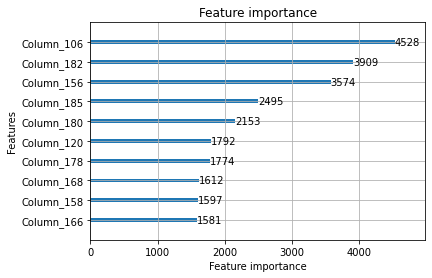

In [ ]:
#plt.figure(figsize=(200,100))
ax = lgbm.plot_importance(ranker,max_num_features=10)#, figsize=(200,100))
plt.show()

In [ ]:
#column_106 - AvgTime for host
#column_182 - USE_NoNnorm
#column_156 - tf_idf_docs
#column_185 - bm25L
#column_180 - USE_words
#column_120 - mean_pos of host for query
#column_178 - Qshow
#column_168 - sDBN(a * s) for host
#column_158 - tf_idf_title_3_13
#column_166 - sDBN(a) for host

(202079, 187)